In [1]:
import tensorflow as tf
import time
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from tqdm import tqdm
# import tifffile
import cv2
import tifffile
image_counter = 0

import torch  
import torch.nn.functional as F 
import math
from PIL import Image

2023-07-17 20:07:11.603234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.version)

Found GPU at: /device:GPU:0
<module 'tensorflow._api.v2.version' from '/data/software/python-libs/3.0.0/envs/tensorflow-2.11-gpu/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


2023-07-17 20:07:14.678115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 20:07:16.514798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 30570 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:27:00.0, compute capability: 7.0


In [3]:
# Set some parameters
im_width = 512
im_height = 512
channels_img = 3
channels_mask = 3

path_train_pots = 'Selected_Images/Subset_Clipped_Potsdam/IrRG/'
path_mask_pots = 'Selected_Images/Subset_Clipped_Potsdam/Mask/'

path_train_vai = 'Selected_Images/Subset_Clipped_Vaihingen/IrRG/'
path_mask_vai =  'Selected_Images/Subset_Clipped_Vaihingen/Mask/'

OUTPUT_CHANNELS = 6
BATCH_SIZE = 4
#Batch_SIZE adjustment ==> was 15
EPOCHS = 200
model_size = 64
BUFFER_SIZE = 100
output_path = 'CGAN_P2V/with TV and SSIM/'

print(path_train_pots)
print(path_train_vai)

Selected_Images/Subset_Clipped_Potsdam/IrRG/
Selected_Images/Subset_Clipped_Vaihingen/IrRG/


In [4]:
###########################################################################
#Load the image data, mask data and unique RGB values in the mask data.#####
############################################################################


def get_data(path_train, path_mask, train=True):
    ##This line of the program extracts unique values in each RGB image and does it repeatedly for all images. 
    temp_unique_list=[]
    ids = next(os.walk(path_train))[2]
    print(ids)
    X = np.zeros((len(ids), im_height, im_width, channels_img), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, channels_mask), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        #### Load images ####
        img = tifffile.imread(path_train + id_)
        
        #Reshape images
        x_img = cv2.resize(img, (im_width, im_height),interpolation = cv2.INTER_LINEAR)
        
        #Normalize between -1 to 1 excluding NDVI
        x_img = (x_img / 127.5) - 1
  
        #### Load masks ####
        if train:
            ##Reading Mask
            mask = tifffile.imread(path_mask + id_)
            #Unique values in a single image
            x3 = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
            #Store all unique RGB values of every image
            temp_unique_list.append(x3)
            mask = cv2.resize(mask, (im_width,im_height),interpolation = cv2.INTER_NEAREST)
        
        # Save images
        X[n] = x_img.squeeze()
        if train:
            y[n] = mask
    print('Done! Loading')
    print('Finding Unique Values in Mask')
    #Convert an array of separate lists for each image to a single list
    temp_single_unique_list = [temp_unique_list[i][j] for  i in range(len(temp_unique_list)) for j in range(len(temp_unique_list[i])) ]
    #Convert the list to a numpy array
    temp_uniq_np = np.array(temp_single_unique_list)
    #Find unique values in the single list
    final_unique =  np.unique(temp_uniq_np, axis=0)
    print(final_unique)
    print(len(final_unique))
                              
    if train:
        return X, y, final_unique
    else:        
      return X

In [5]:
X_P = get_data(path_train_pots, path_mask_pots, train=False)
X_V = get_data(path_train_vai, path_mask_vai, train=False)

print('Shape of Potsdam is: '+str(X_P.shape))
print('Shape of Vaihingen is: '+str(X_V.shape))

['potsdam_2_10_0.tiff', 'potsdam_2_10_1.tiff', 'potsdam_2_10_12.tiff', 'potsdam_2_10_17.tiff', 'potsdam_2_10_2.tiff', 'potsdam_2_10_24.tiff', 'potsdam_2_10_3.tiff', 'potsdam_2_11_16.tiff', 'potsdam_2_11_17.tiff', 'potsdam_2_11_18.tiff', 'potsdam_2_11_19.tiff', 'potsdam_2_11_21.tiff', 'potsdam_2_11_22.tiff', 'potsdam_2_11_3.tiff', 'potsdam_2_11_4.tiff', 'potsdam_2_12_0.tiff', 'potsdam_2_12_1.tiff', 'potsdam_2_12_10.tiff', 'potsdam_2_12_11.tiff', 'potsdam_2_12_2.tiff', 'potsdam_2_12_5.tiff', 'potsdam_2_12_6.tiff', 'potsdam_2_13_1.tiff', 'potsdam_2_13_10.tiff', 'potsdam_2_13_11.tiff', 'potsdam_2_13_13.tiff', 'potsdam_2_13_14.tiff', 'potsdam_2_13_15.tiff', 'potsdam_2_13_16.tiff', 'potsdam_2_13_17.tiff', 'potsdam_2_13_18.tiff', 'potsdam_2_13_19.tiff', 'potsdam_2_13_2.tiff', 'potsdam_2_13_20.tiff', 'potsdam_2_13_21.tiff', 'potsdam_2_13_22.tiff', 'potsdam_2_13_23.tiff', 'potsdam_2_13_24.tiff', 'potsdam_2_13_3.tiff', 'potsdam_2_13_4.tiff', 'potsdam_2_13_6.tiff', 'potsdam_2_13_7.tiff', 'potsdam

100%|██████████| 212/212 [00:01<00:00, 186.24it/s]


Done! Loading
Finding Unique Values in Mask
[]
0
['top_mosaic_09cm_area10_0.tiff', 'top_mosaic_09cm_area10_10.tiff', 'top_mosaic_09cm_area10_11.tiff', 'top_mosaic_09cm_area10_12.tiff', 'top_mosaic_09cm_area10_13.tiff', 'top_mosaic_09cm_area10_14.tiff', 'top_mosaic_09cm_area10_3.tiff', 'top_mosaic_09cm_area10_4.tiff', 'top_mosaic_09cm_area10_6.tiff', 'top_mosaic_09cm_area10_7.tiff', 'top_mosaic_09cm_area10_8.tiff', 'top_mosaic_09cm_area10_9.tiff', 'top_mosaic_09cm_area11_1.tiff', 'top_mosaic_09cm_area11_12.tiff', 'top_mosaic_09cm_area11_2.tiff', 'top_mosaic_09cm_area11_3.tiff', 'top_mosaic_09cm_area11_4.tiff', 'top_mosaic_09cm_area11_5.tiff', 'top_mosaic_09cm_area11_6.tiff', 'top_mosaic_09cm_area11_7.tiff', 'top_mosaic_09cm_area11_8.tiff', 'top_mosaic_09cm_area11_9.tiff', 'top_mosaic_09cm_area12_0.tiff', 'top_mosaic_09cm_area12_1.tiff', 'top_mosaic_09cm_area12_10.tiff', 'top_mosaic_09cm_area12_11.tiff', 'top_mosaic_09cm_area12_12.tiff', 'top_mosaic_09cm_area12_13.tiff', 'top_mosaic_09cm

100%|██████████| 309/309 [00:00<00:00, 363.11it/s]

Done! Loading
Finding Unique Values in Mask
[]
0
Shape of Potsdam is: (212, 512, 512, 3)
Shape of Vaihingen is: (309, 512, 512, 3)


In [6]:
X_train_P_tf = tf.data.Dataset.from_tensor_slices(X_P)
X_train_V_tf = tf.data.Dataset.from_tensor_slices(X_V)

2023-07-17 20:07:18.536346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30570 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:27:00.0, compute capability: 7.0


In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[im_height, im_width, 3])

  return cropped_image

In [8]:
@tf.function()
def random_jitter(input_image):
    
    new_w = int(1.1*im_width)
    new_h = int(1.1*im_height)
    
    input_image = tf.image.resize(input_image, [new_w, new_h],
                                  method=tf.image.ResizeMethod.BILINEAR)
    
    # Random cropping back to 256x256
    input_image = random_crop(input_image)
  
    if tf.random.uniform(()) > 0.5:
      # Random mirroring
      input_image = tf.image.flip_left_right(input_image)
      
    if tf.random.uniform(()) > 0.5:
      # Random mirroring
      input_image = tf.image.rot90(input_image, k = 1)
  
    return input_image

In [9]:
def preprocess_image_train(image):#, label):
  image = random_jitter(image)
  # image = normalize(image)
  return image

In [10]:
train_pots = X_train_P_tf.map(
    preprocess_image_train, num_parallel_calls = tf.data.AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_vai = X_train_V_tf.map(
    preprocess_image_train, num_parallel_calls = tf.data.AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
#One sample has 8 batch size(for 1 iteration)
sample_pots = next(iter(train_pots))
sample_vai = next(iter(train_vai))

In [12]:
tf.image.total_variation(sample_pots[0]).numpy()

59691.496

2023-07-17 20:07:20.396361: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond_1/then/_8/cond_1/rot90/Assert/AssertGuard/branch_executed/_40


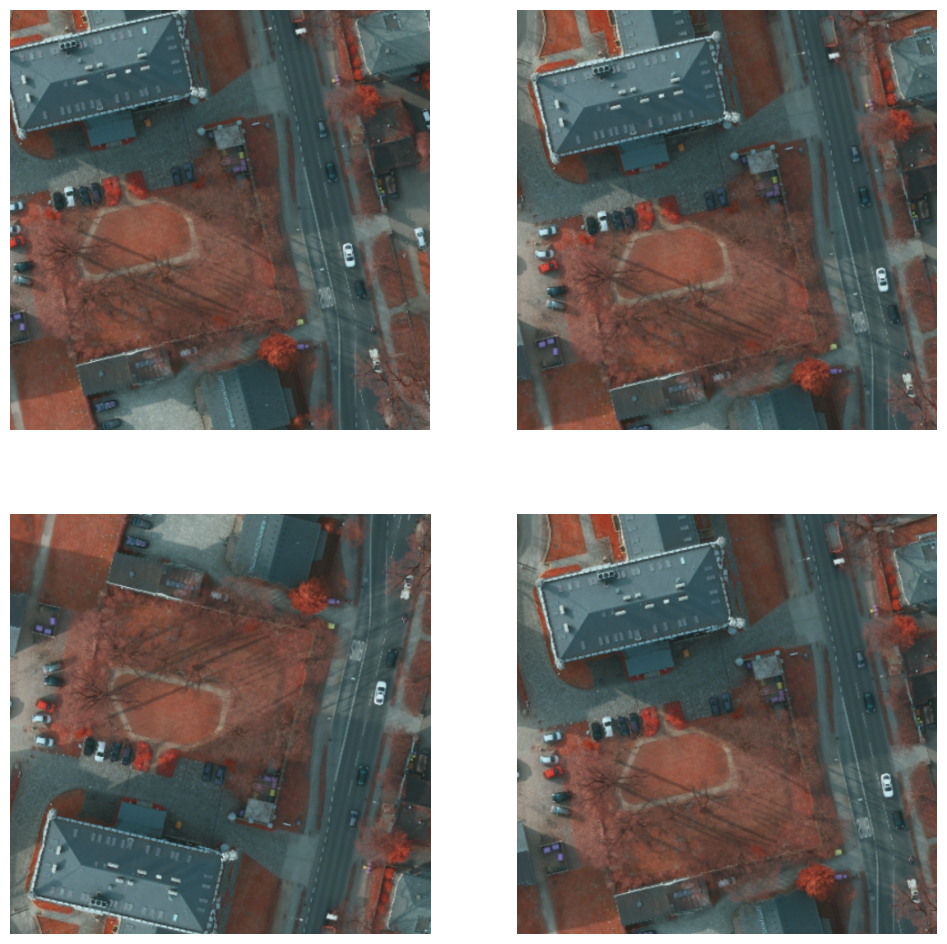

<Figure size 640x480 with 0 Axes>

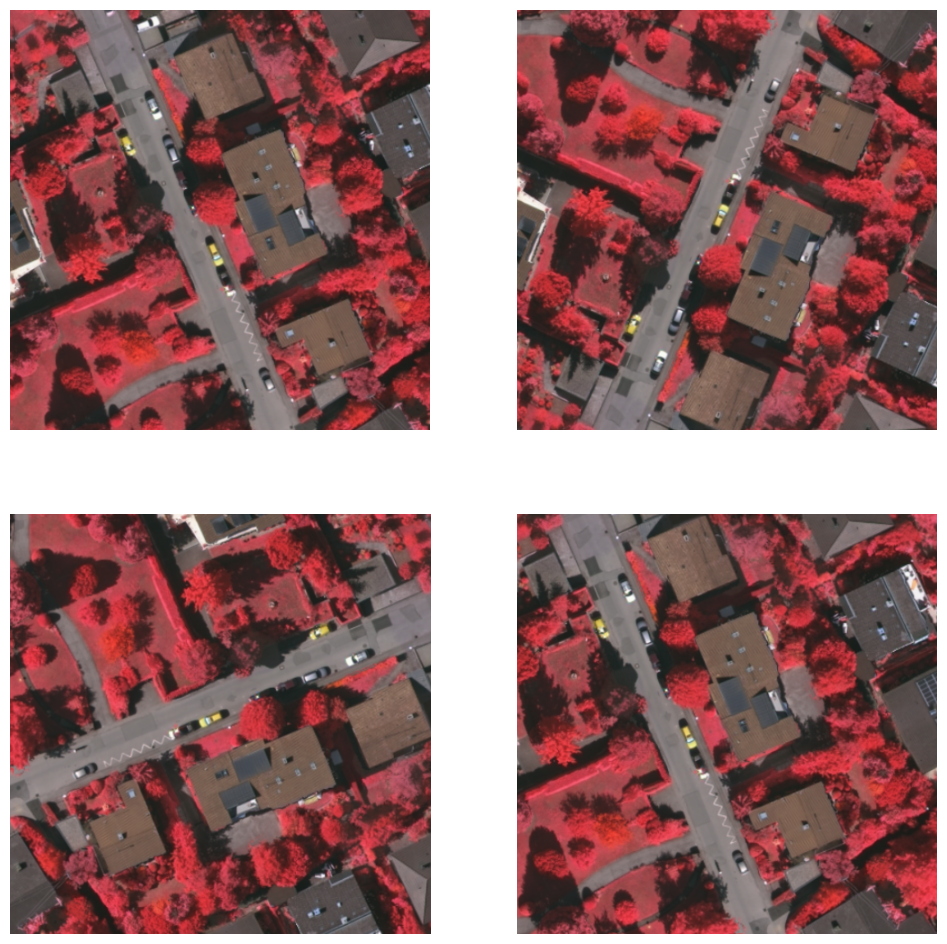

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(12, 12))
for i in range(4):
  plt.subplot(2, 2, i + 1)
  plt.imshow(random_jitter(sample_pots[0])* 0.5 + 0.5)
  plt.axis('off')
plt.show()
plt.savefig(output_path+'Demo_Potsdam_Jitter.png', bbox_inches='tight')
plt.clf()

plt.figure(figsize=(12, 12))
for i in range(4):
  plt.subplot(2, 2, i + 1)
  plt.imshow(random_jitter(sample_vai[0])* 0.5 + 0.5)
  plt.axis('off')
plt.show()
plt.savefig(output_path+'Demo_Vaihingen_Jitter.png', bbox_inches='tight')
plt.clf()

In [14]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon


  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'epsilon': self.epsilon,
            })
      return config


  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [15]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [16]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
generator_g = unet_generator(channels_img, norm_type='instancenorm')
generator_f = unet_generator(channels_img, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

2023-07-17 20:07:23.269504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


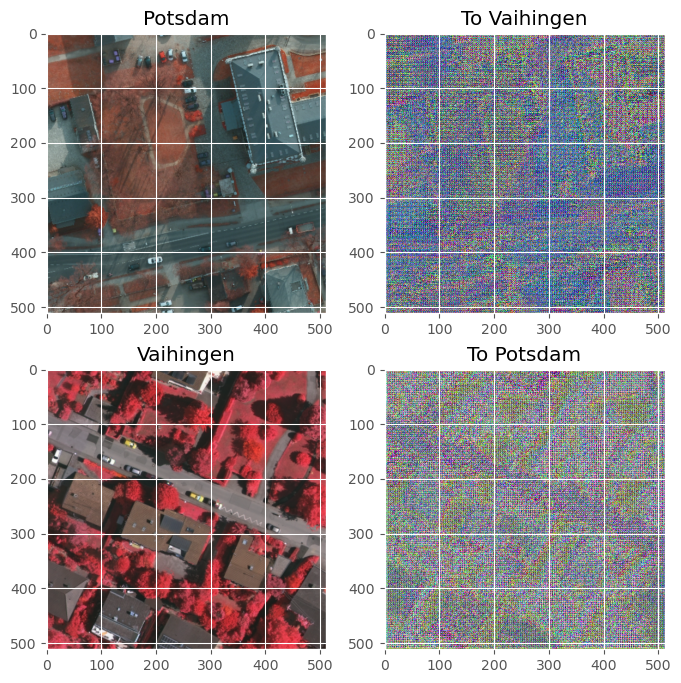

In [20]:
to_vai = generator_g(sample_pots)
to_pots = generator_f(sample_vai)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_pots, to_vai, sample_vai, to_pots]
title = ['Potsdam', 'To Vaihingen', 'Vaihingen', 'To Potsdam']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0]* 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.savefig(output_path+'Demo_P2V_V2P_Ex.png', bbox_inches='tight')
#plt.clf()

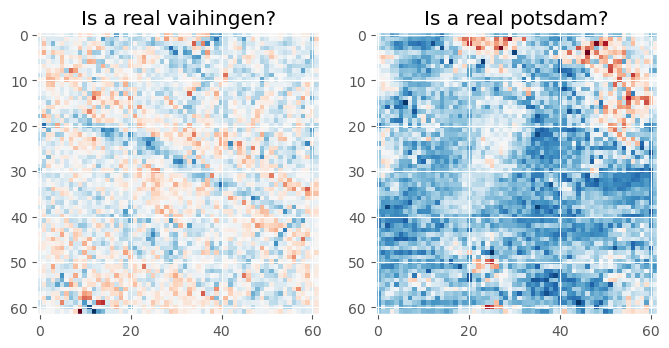

In [21]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real vaihingen?')
plt.imshow(discriminator_y(sample_vai)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real potsdam?')
plt.imshow(discriminator_x(sample_pots)[0, ..., -1], cmap='RdBu_r')
plt.savefig(output_path+'Demo_P2V_Disc_Ex.png', bbox_inches='tight')
#plt.clf()

In [22]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
checkpoint_path = output_path+"checkpoints/checkpoint"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

In [24]:
def generate_images(model, test_input, num):
    plt.clf()
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i]* 0.5 + 0.5)
        plt.axis('off')
  
    plt.savefig(output_path+'Training_Progress_'+str(num)+'.png', bbox_inches='tight')

In [25]:
#testing SSIM
fake_y = generator_g(sample_pots, training=True)
cycled_x = generator_f(fake_y, training=True)


ssim_loss_real_x = 1-tf.reduce_mean(tf.image.ssim(sample_pots, cycled_x, max_val=1.0))

print(ssim_loss_real_x)

tf.Tensor(1.0010735, shape=(), dtype=float32)


In [26]:
"""# Define the loss weights as TensorFlow variables
gen_g_loss_weight = tf.Variable(1.0, name="gen_g_loss_weight", trainable=True)
gen_f_loss_weight = tf.Variable(1.0, name="gen_f_loss_weight", trainable=True)
identify_g_loss_weight = tf.Variable(1.0, name="identify_g_loss_weight", trainable=True)
identify_f_loss_weight = tf.Variable(1.0, name="identify_f_loss_weight", trainable=True)
total_cycle_loss_weight = tf.Variable(1.0, name="total_cycle_loss_weight", trainable=True)
ssim_loss_fake_y_weight = tf.Variable(1.0, name="ssim_loss_fake_y_weight", trainable=True)
ssim_loss_fake_x_weight = tf.Variable(1.0, name="ssim_loss_fake_x_weight", trainable=True)
tv_loss_fake_y_weight = tf.Variable(1.0, name="tv_loss_fake_y_weight", trainable=True)
tv_loss_fake_x_weight = tf.Variable(1.0, name="tv_loss_fake_x_weight", trainable=True)"""

'# Define the loss weights as TensorFlow variables\ngen_g_loss_weight = tf.Variable(1.0, name="gen_g_loss_weight", trainable=True)\ngen_f_loss_weight = tf.Variable(1.0, name="gen_f_loss_weight", trainable=True)\nidentify_g_loss_weight = tf.Variable(1.0, name="identify_g_loss_weight", trainable=True)\nidentify_f_loss_weight = tf.Variable(1.0, name="identify_f_loss_weight", trainable=True)\ntotal_cycle_loss_weight = tf.Variable(1.0, name="total_cycle_loss_weight", trainable=True)\nssim_loss_fake_y_weight = tf.Variable(1.0, name="ssim_loss_fake_y_weight", trainable=True)\nssim_loss_fake_x_weight = tf.Variable(1.0, name="ssim_loss_fake_x_weight", trainable=True)\ntv_loss_fake_y_weight = tf.Variable(1.0, name="tv_loss_fake_y_weight", trainable=True)\ntv_loss_fake_x_weight = tf.Variable(1.0, name="tv_loss_fake_x_weight", trainable=True)'

In [27]:
@tf.function
def train_step(real_x, real_y):
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total variation loss
        tv_loss_real_x = tf.reduce_sum(tf.image.total_variation(real_x))
        tv_loss_real_y = tf.reduce_sum(tf.image.total_variation(real_y))
        tv_loss_fake_x = tf.reduce_sum(tf.image.total_variation(fake_x))
        tv_loss_fake_y = tf.reduce_sum(tf.image.total_variation(fake_y))
        
        # Calculate SSIM loss
        #originally, higher the better: 1 = perfect uniformity
        #however, now it's higher the worse.
        ssim_loss_real_x = 1 - tf.reduce_mean(tf.image.ssim(real_x, cycled_x, max_val=1.0))
        ssim_loss_real_y = 1 - tf.reduce_mean(tf.image.ssim(real_y, cycled_y, max_val=1.0))
        ssim_loss_fake_x = 1 - tf.reduce_mean(tf.image.ssim(real_x, fake_x, max_val=1.0))
        ssim_loss_fake_y = 1 - tf.reduce_mean(tf.image.ssim(real_y, fake_y, max_val=1.0))
        
        # Total generator loss = adversarial loss + cycle loss + SSIM loss + total variation loss + SSIM
        total_gen_g_loss = gen_g_loss + total_cycle_loss+ identity_loss(real_y, same_y)+ ssim_loss_real_x+ssim_loss_real_y+ tv_loss_fake_y
        total_gen_f_loss = gen_f_loss + total_cycle_loss+ identity_loss(real_x, same_x)+ ssim_loss_real_x+ssim_loss_real_y+ tv_loss_fake_x

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return gen_g_loss, gen_f_loss, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss, tv_loss_fake_x, tv_loss_fake_y, ssim_loss_real_x, ssim_loss_real_y


In [ ]:
start_time = time.time()
genGLoss = []
genFLoss = []
cycLoss = []
totgenGLoss = []
totgenFLoss = []
discXLoss = []
discYLoss = []
tv_loss_fake_x = [] #total variation (fake_x = vaihingen in potsdam style)
tv_loss_fake_y = [] #total variation (fake_y = potsdam in vaihingen style)
ssim_loss_real_x = []
ssim_loss_real_y = []
#weights=[] #2D array

for epoch in range(EPOCHS):
    start = time.time()
    
    for image_x, image_y in tf.data.Dataset.zip((train_pots, train_vai)):
        l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11 = train_step(image_x, image_y)
    
    # Using a consistent image (sample_potsdam) so that the progress of the model
    # is clearly visible.
    # Read out training results
    genGLoss.append(float(l1))
    genFLoss.append(float(l2))
    cycLoss.append(float(l3))
    totgenGLoss.append(float(l4))
    totgenFLoss.append(float(l5)) 
    discXLoss.append(float(l6))
    discYLoss.append(float(l7)) 
    tv_loss_fake_x.append(float(l8))
    tv_loss_fake_y.append(float(l9))
    ssim_loss_real_x.append(float(l10))
    ssim_loss_real_y.append(float(l11))
    #weights.append([gen_g_loss_weight, gen_f_loss_weight, identify_g_loss_weight, identify_f_loss_weight, total_cycle_loss_weight, ssim_loss_fake_y_weight, ssim_loss_fake_x_weight, tv_loss_fake_y_weight, tv_loss_fake_x_weight])
    
    readout = 'Losses: Gen G(P2V): {}, Gen F(V2P): {}, Cycle: {}, TGen G(P2V): {}, TGen F(V2P): {}, DiscX: {}, DiscY: {}., \n tv_fakeY(Potsdam -> vaihingen): {}., tv_fakeX(Vaihingen -> Potsdam): {} \n ssim_loss_real_x: {}., ssim_loss_real_y: {}'
    print(readout.format(l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11))
    print("\n\n\n")
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
   
    if (epoch%20 == 0):
        generate_images(generator_g, sample_pots, epoch)
    
    if (epoch + 1) % 10 == 0:
        checkpoint_prefix = os.path.join(checkpoint_path, str(epoch+1))
        ckpt.save(file_prefix=checkpoint_prefix)
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, checkpoint_prefix))

print('##################################################################')
print("Model training time in seconds: "+str(time.time() - start_time))

2023-07-17 20:07:43.288999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-17 20:07:45.443870: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55886b91b990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 20:07:45.443906: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-07-17 20:07:45.449136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 20:07:45.547367: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Losses: Gen G(P2V): 2.536694288253784, Gen F(V2P): 2.304166555404663, Cycle: 7.28800106048584, TGen G(P2V): 108201.1484375, TGen F(V2P): 93036.546875, DiscX: 0.10901114344596863, DiscY: 0.19346648454666138., 
 tv_fakeY(Potsdam -> vaihingen): 93023.2265625., tv_fakeX(Vaihingen -> Potsdam): 108187.40625 
 ssim_loss_real_x: 1.0118578672409058., ssim_loss_real_y: 0.9840608239173889




Time taken for epoch 1 is 64.87586283683777 sec

Losses: Gen G(P2V): 3.6037437915802, Gen F(V2P): 3.6083319187164307, Cycle: 7.409594535827637, TGen G(P2V): 58554.765625, TGen F(V2P): 68358.6171875, DiscX: 0.03133445233106613, DiscY: 0.04661256819963455., 
 tv_fakeY(Potsdam -> vaihingen): 68343.8359375., tv_fakeX(Vaihingen -> Potsdam): 58539.8046875 
 ssim_loss_real_x: 1.0217602252960205., ssim_loss_real_y: 0.9831213355064392




Time taken for epoch 2 is 40.246487855911255 sec

Losses: Gen G(P2V): 4.176731586456299, Gen F(V2P): 4.1635541915893555, Cycle: 7.209845542907715, TGen G(P2V): 51891.03125, TGen F(V

Losses: Gen G(P2V): 7.791563510894775, Gen F(V2P): 7.685548782348633, Cycle: 7.485776424407959, TGen G(P2V): 13555.8974609375, TGen F(V2P): 11134.1962890625, DiscX: 0.0006860619178041816, DiscY: 0.0007068602717481554., 
 tv_fakeY(Potsdam -> vaihingen): 11114.943359375., tv_fakeX(Vaihingen -> Potsdam): 13537.029296875 
 ssim_loss_real_x: 1.1270523071289062., ssim_loss_real_y: 0.8352169990539551




Time taken for epoch 20 is 40.59136247634888 sec

Saving checkpoint for epoch 20 at CGAN_P2V/with TV and SSIM/checkpoints/checkpoint/20
Losses: Gen G(P2V): 8.47311019897461, Gen F(V2P): 7.745484828948975, Cycle: 8.269888877868652, TGen G(P2V): 14419.822265625, TGen F(V2P): 9252.8125, DiscX: 0.0004028325201943517, DiscY: 0.0005945589509792626., 
 tv_fakeY(Potsdam -> vaihingen): 9232.25390625., tv_fakeX(Vaihingen -> Potsdam): 14399.4521484375 
 ssim_loss_real_x: 1.1925493478775024., ssim_loss_real_y: 0.822197675704956




Time taken for epoch 21 is 39.83494448661804 sec

Losses: Gen G(P2V): 8.3

Losses: Gen G(P2V): 6.211363315582275, Gen F(V2P): 8.527814865112305, Cycle: 8.831021308898926, TGen G(P2V): 7775.20556640625, TGen F(V2P): 6741.18994140625, DiscX: 0.00019629606686066836, DiscY: 0.0028876117430627346., 
 tv_fakeY(Potsdam -> vaihingen): 6718.859375., tv_fakeX(Vaihingen -> Potsdam): 7756.6044921875 
 ssim_loss_real_x: 1.2241474390029907., ssim_loss_real_y: 0.830683171749115




Time taken for epoch 38 is 40.57770395278931 sec

Losses: Gen G(P2V): 6.5438618659973145, Gen F(V2P): 8.342204093933105, Cycle: 8.29179573059082, TGen G(P2V): 6816.27197265625, TGen F(V2P): 5407.2744140625, DiscX: 0.00022796029224991798, DiscY: 0.0013311062939465046., 
 tv_fakeY(Potsdam -> vaihingen): 5385.78759765625., tv_fakeX(Vaihingen -> Potsdam): 6798.2177734375 
 ssim_loss_real_x: 1.2011711597442627., ssim_loss_real_y: 0.7592807412147522




Time taken for epoch 39 is 40.61191964149475 sec

Losses: Gen G(P2V): 6.656750202178955, Gen F(V2P): 8.470904350280762, Cycle: 8.537019729614258, TGen 

Losses: Gen G(P2V): 8.405372619628906, Gen F(V2P): 9.183337211608887, Cycle: 9.662925720214844, TGen G(P2V): 4046.0029296875, TGen F(V2P): 3710.145263671875, DiscX: 9.764562855707482e-05, DiscY: 0.000252763566095382., 
 tv_fakeY(Potsdam -> vaihingen): 3685.93798828125., tv_fakeX(Vaihingen -> Potsdam): 4024.4892578125 
 ssim_loss_real_x: 1.213735818862915., ssim_loss_real_y: 0.7722852230072021




Time taken for epoch 56 is 40.52341079711914 sec

Losses: Gen G(P2V): 8.478989601135254, Gen F(V2P): 9.51959228515625, Cycle: 9.482833862304688, TGen G(P2V): 3542.400634765625, TGen F(V2P): 4455.0185546875, DiscX: 7.549457950517535e-05, DiscY: 0.0001720348373055458., 
 tv_fakeY(Potsdam -> vaihingen): 4430.712890625., tv_fakeX(Vaihingen -> Potsdam): 3521.021484375 
 ssim_loss_real_x: 1.2178356647491455., ssim_loss_real_y: 0.7711473703384399




Time taken for epoch 57 is 40.54819393157959 sec

Losses: Gen G(P2V): 8.580290794372559, Gen F(V2P): 9.007383346557617, Cycle: 10.165412902832031, TGen 

Losses: Gen G(P2V): 7.750310897827148, Gen F(V2P): 9.690550804138184, Cycle: 10.88039779663086, TGen G(P2V): 7478.80419921875, TGen F(V2P): 2853.6669921875, DiscX: 7.077507325448096e-05, DiscY: 0.0003418772539589554., 
 tv_fakeY(Potsdam -> vaihingen): 2827.326904296875., tv_fakeX(Vaihingen -> Potsdam): 7456.5654296875 
 ssim_loss_real_x: 1.175380825996399., ssim_loss_real_y: 0.7920124530792236




Time taken for epoch 74 is 40.436659812927246 sec

Losses: Gen G(P2V): 9.216632843017578, Gen F(V2P): 9.864583015441895, Cycle: 11.683884620666504, TGen G(P2V): 1719.7003173828125, TGen F(V2P): 2452.4443359375, DiscX: 4.650454502552748e-05, DiscY: 8.994448580779135e-05., 
 tv_fakeY(Potsdam -> vaihingen): 2424.697265625., tv_fakeX(Vaihingen -> Potsdam): 1695.0394287109375 
 ssim_loss_real_x: 1.2591512203216553., ssim_loss_real_y: 0.7985973358154297




Time taken for epoch 75 is 40.568203926086426 sec

Losses: Gen G(P2V): 9.399091720581055, Gen F(V2P): 9.854120254516602, Cycle: 11.093021392822

In [ ]:
# Save the final weights in a separate file
check_gen_g_path = output_path+"checkpoints/GenG/"
check_gen_f_path = output_path+"checkpoints/GenF/"
check_disc_x_path = output_path+"checkpoints/DisX/"
check_disc_y_path = output_path+"checkpoints/DisY/"

generator_g.save_weights(check_gen_g_path)
generator_f.save_weights(check_gen_f_path)
discriminator_x.save_weights(check_disc_x_path)
discriminator_y.save_weights(check_disc_y_path)


# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
generator_g.save(output_path+"Generator_G_P2V_"+str(model_size))
generator_f.save(output_path+"Generator_F_V2P_"+str(model_size))
discriminator_x.save(output_path+"Discriminator_X_P_"+str(model_size))
discriminator_y.save(output_path+"Discriminator_Y_V_"+str(model_size))

In [ ]:
train_accuracy_results = []
rec_loss_results = []
n_loss = []
merged_results = np.asarray([genGLoss, genFLoss, cycLoss, totgenGLoss, totgenFLoss, discXLoss, discYLoss])


merged_results = merged_results.T
print('Gen G(P2V), Gen F(V2P), Cycle, TGen G(P2V), TGen F(V2P), DiscX, DiscY losses in a file')
print(merged_results)
np.savetxt(output_path+'metrics_M'+str(model_size)+'.csv',merged_results,delimiter=",")

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Generator Loss curve comparison")
plt.plot(genGLoss, label="Generator_P", color = "red")
plt.plot(genFLoss, label="Generator_V", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
plt.show()
plt.savefig(output_path+'Generator_loss_M'+str(model_size)+'.png', bbox_inches='tight')
plt.clf()


plt.figure(figsize=(8, 8))
plt.title("Cycle Loss")
plt.plot(cycLoss, label="Generator_P", color = "red")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
plt.show()
plt.savefig(output_path+'Cycle_loss_M'+str(model_size)+'.png', bbox_inches='tight')
plt.clf()


plt.figure(figsize=(8, 8))
plt.title("Total Generator Loss curve comparison")
plt.plot(totgenGLoss, label="Gen_Cyc_P", color = "red")
plt.plot(totgenFLoss, label="Gen_Cyc_V", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
plt.show()
plt.savefig(output_path+'Gen_Cyc_loss_M'+str(model_size)+'.png', bbox_inches='tight')
plt.clf()

plt.figure(figsize=(8, 8))
plt.title("Discriminator Loss curve comparison")
plt.plot(discXLoss, label="Disc_P", color = "red")
plt.plot(discYLoss, label="Disc_V", color = "blue")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();
plt.show()
plt.savefig(output_path+'Discriminator_loss_M'+str(model_size)+'.png', bbox_inches='tight')
plt.clf()

In [ ]:
print(1)